In [1]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nuclease_design import utils
from nuclease_design import plotting
from nuclease_design import constants


/var/folders/4g/l2k88w8157j_55v45frbffd0jyc_91/T/ipykernel_3115/1096426316.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load data

In [3]:
RANDOM_SEED = 226
DATA_DIR = constants.DATA_DIR

In [4]:
%%time
all_data_df = utils.load_all_data(DATA_DIR)
df = utils.expand_sublibraries(all_data_df)
df['campaign'] = df['sublibrary_name'].apply(utils.sublibrary_name_to_campaign_name)
sublibrary_rename_dict = dict(g4_mbo_dnn='ML4-MBO-DNN', g4_hit_recombination='HR4')
df['short_sublibrary_name'] = df['sublibrary_name'].apply(lambda s: sublibrary_rename_dict.get(s, None))

CPU times: user 2.93 s, sys: 290 ms, total: 3.22 s
Wall time: 8.21 s


# Hit-rate per radius

Text(10.097222222222216, 0.5, 'Hit rate')

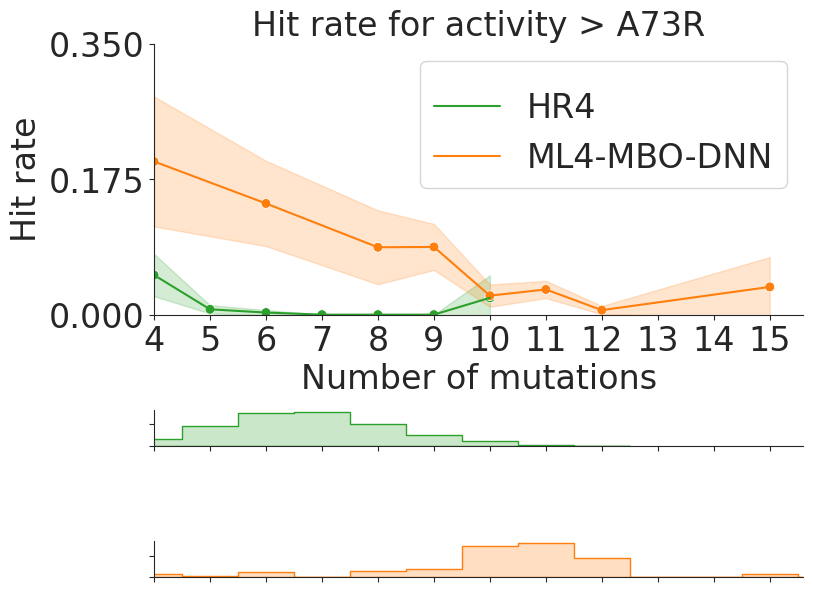

In [5]:
fig = plt.figure(figsize=(8, 6))

systems = ['g4_mbo_dnn', 'g4_hit_recombination']
ax = plotting.plot_hit_rate_per_num_mutations_with_histogram(df[df['sublibrary_name'].isin(systems)],
    reference_name='a73r',
    hue_feature='short_sublibrary_name',
    hue_order=['HR4', 'ML4-MBO-DNN'],
    palette=[plotting.HR_COLOR, plotting.ML_COLOR],
    group_cols=['short_sublibrary_name', 'num_mutations'],
    random_seed=RANDOM_SEED, fontsize=24)

ax.get_legend().get_title().set_text(None)
ax.get_legend().get_title().set_fontsize(1)

ax.set_yticks(np.linspace(0, 0.35, 3))
ax.set_xlim(left=4.0)

ax.set_xlabel('Number of mutations')
ax.set_ylabel('Hit rate')


In [6]:
def make_plot(df, systems, reference, palette=None, rename_dict=None):
    plt.figure(figsize=(12, 10))

    df = df.copy()
    df['library'] = df['sublibrary_name']
    if rename_dict is not None:
      df = df.copy()
      df['library'] = df['library'].apply(lambda s: rename_dict.get(s, s))
      systems = [rename_dict[s] for s in systems]
    ax = plotting.plot_hit_rate_per_num_mutations_with_histogram(
        df[df['library'].isin(systems)],
        reference_name=reference,
        hue_feature='library',
        hue_order=systems,
        palette=palette,
        group_cols=['library', 'num_mutations'],
        random_seed=RANDOM_SEED,
        fontsize=30
    )
    return ax

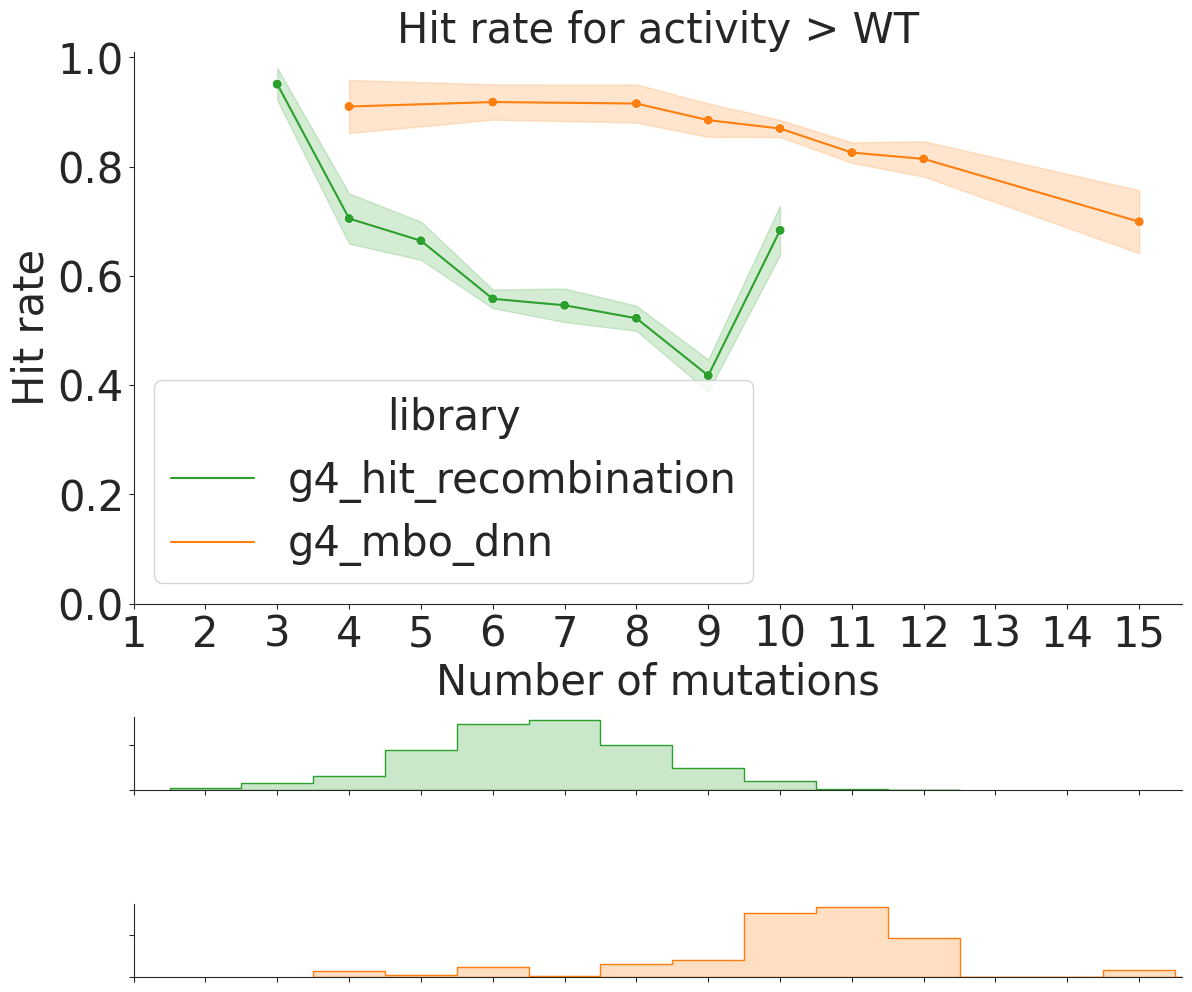

In [7]:
ax = make_plot(df, ['g4_hit_recombination', 'g4_mbo_dnn'], 'wt', [plotting.HR_COLOR, plotting.ML_COLOR])

# Make big tables of hit rates stats to put in the Supplement

In [8]:
stats_dfs = {}
stats_dfs['neg_control'] = utils.get_bootstrapped_hit_rate_stats(
    df,
    'neg_control',
    random_seed=RANDOM_SEED,
)

stats_dfs['wt'] = utils.get_bootstrapped_hit_rate_stats(
    df,
    'wt',
    random_seed=RANDOM_SEED,
)

stats_dfs['A73R'] = utils.get_bootstrapped_hit_rate_stats(
    df[df['generation'].isin(['g3', 'g4'])],
    'a73r',
    random_seed=RANDOM_SEED,
)


for fiducial in ['a73r_d74s', 'a63p_a73r_d74h_i84y']:
  stats_dfs[fiducial] = utils.get_bootstrapped_hit_rate_stats(
      df[df['generation'] == 'g4'],
      fiducial,
      random_seed=RANDOM_SEED,
  )

In [9]:
def _render_with_errorbar(row, field, num_decimals, use_percentage) -> str:
  format_str = f'%0.0{num_decimals}f +/- %0.0{num_decimals}f'
  factor = 100 if use_percentage else 1
  return format_str % (factor * row[(field, 'mean')], factor * row[(field, 'std')])


def _render_stats_table(hit_rate_stats_df) -> str:
  rows = []
  for raw_row in hit_rate_stats_df.reset_index().to_dict('records'):
    row = dict(name=raw_row[('sublibrary_name', '')])
    row['num hits'] = _render_with_errorbar(raw_row, 'num_hits', 1, use_percentage=False)
    row['hit rate'] = _render_with_errorbar(raw_row, 'hit_rate', 2, use_percentage=True)
    row['library size'] = int(raw_row[('library_size', 'mean')])
    rows.append(row)
  return pd.DataFrame(rows)


def _format_columns(df, ref_name):
  return df.rename(
      columns={key: f'{key} (> {ref_name})' for key in ['num hits', 'hit rate']}
  )


def make_table(stats_dfs, group_order, name_to_generation):
  stats_dfs = {
      key: _format_columns(_render_stats_table(df), key)
      for key, df in stats_dfs.items()
  }
  to_return = stats_dfs[group_order[0]]
  for group in group_order[1:]:
    to_return = to_return.merge(
        stats_dfs[group].drop(columns='library size'), on='name', how='outer'
    ).fillna('N/A')

  to_return['generation'] = to_return['name'].apply(name_to_generation.get)
  first_columns = ['generation', 'name', 'library size']
  col_order = first_columns + [c for c in to_return.columns if c not in first_columns]
  return to_return[col_order]


In [10]:
name_to_generation = df.groupby('sublibrary_name')['generation'].first().to_dict()
name_to_generation['zero_shot'] = 'alternative to g1'
name_to_generation['prosar+screen_g2_redux'] = 'alternative to g2'

table = make_table(stats_dfs, ['neg_control', 'wt', 'A73R'], name_to_generation)
table.head()

,generation,name,library size,num hits (> neg_control),hit rate (> neg_control),num hits (> wt),hit rate (> wt),num hits (> A73R),hit rate (> A73R)
0,g1,g1_eppcr,9441,1084.5 +/- 33.0,11.49 +/- 0.35,155.1 +/- 10.0,1.64 +/- 0.11,N/A,N/A
1,g2,g2_broad_recombination_sampling,3598,99.5 +/- 9.5,2.76 +/- 0.26,6.1 +/- 3.5,0.17 +/- 0.10,N/A,N/A
2,g2,g2_g1_plate_assay_variants,5,5.0 +/- 0.0,100.00 +/- 0.00,3.7 +/- 0.9,73.33 +/- 17.99,N/A,N/A
3,g2,g2_hit_recombination,951,830.9 +/- 12.5,87.37 +/- 1.32,470.0 +/- 10.1,49.42 +/- 1.06,N/A,N/A
4,g2,g2_mbo_dnn_exploit,287,104.5 +/- 9.7,36.40 +/- 3.37,43.1 +/- 7.5,15.03 +/- 2.63,N/A,N/A


In [11]:
import scipy.stats as stats

def get_chi_square_pvalue_for_hit_rates(n_a, n_hits_a, n_b, n_hits_b):
    observed = [[n_hits_a, n_a - n_hits_a],
                [n_hits_b, n_b - n_hits_b]]

    chi2, p, _, _ = stats.chi2_contingency(observed)
    return p

In [29]:
def get_lib_size_and_num_hits(method, ref_name, table):
    subtable = table[table['name'] == method]
    hit_column = f'num hits (> {ref_name})'
    num_hits = float(subtable[hit_column].item().split()[0])
    return subtable['library size'].item(), num_hits

def compare(method_a, method_b, ref_name, hit_table):
    n_a, n_hits_a = get_lib_size_and_num_hits(method_a, ref_name, hit_table)
    n_b, n_hits_b = get_lib_size_and_num_hits(method_b, ref_name, hit_table)
    pvalue = get_chi_square_pvalue_for_hit_rates(n_a, n_hits_a, n_b, n_hits_b)
    print(f'{method_a} vs {method_b} at {ref_name}, P={pvalue:0.3e}')

compare('g4_mbo_dnn', 'g4_hit_recombination', 'A73R', table)
compare('zero_shot', 'g1_eppcr', 'neg_control', table)
compare('zero_shot', 'g1_eppcr', 'wt', table)

g4_mbo_dnn vs g4_hit_recombination at A73R, P=1.284e-09
zero_shot vs g1_eppcr at neg_control, P=1.402e-275
zero_shot vs g1_eppcr at wt, P=1.612e-78


In [ ]:
# TO put this table in the paper:
# 1) paste the text into a local csv file
# 2) upload the file to google sheets
# 3) paste the sheet as a table in the paper
print(table.to_csv(index=False, header=True))

generation,name,library size,num hits (> neg_control),hit rate (> neg_control),num hits (> wt),hit rate (> wt),num hits (> A73R),hit rate (> A73R)
g1,g1_eppcr,9441,1084.5 +/- 33.0,11.49 +/- 0.35,155.1 +/- 10.0,1.64 +/- 0.11,N/A,N/A
g2,g2_broad_recombination_sampling,3598,99.5 +/- 9.5,2.76 +/- 0.26,6.1 +/- 3.5,0.17 +/- 0.10,N/A,N/A
g2,g2_g1_plate_assay_variants,5,5.0 +/- 0.0,100.00 +/- 0.00,3.7 +/- 0.9,73.33 +/- 17.99,N/A,N/A
g2,g2_hit_recombination,951,830.9 +/- 12.5,87.37 +/- 1.32,470.0 +/- 10.1,49.42 +/- 1.06,N/A,N/A
g2,g2_mbo_dnn_exploit,287,104.5 +/- 9.7,36.40 +/- 3.37,43.1 +/- 7.5,15.03 +/- 2.63,N/A,N/A
g2,g2_mbo_dnn_explore,4083,1393.9 +/- 27.3,34.14 +/- 0.67,171.7 +/- 20.0,4.20 +/- 0.49,N/A,N/A
g2,g2_single_mutants,1402,384.4 +/- 12.7,27.42 +/- 0.91,43.0 +/- 6.3,3.07 +/- 0.45,N/A,N/A
g2,g2_stratified_sample,40,16.2 +/- 3.6,40.50 +/- 9.12,2.7 +/- 1.7,6.83 +/- 4.27,N/A,N/A
g2,g2_unmatched,4365,446.8 +/- 18.3,10.24 +/- 0.42,103.9 +/- 11.8,2.38 +/- 0.27,N/A,N/A
g2,g2_wt_synonyms,1,1

In [ ]:
stats_dfs['a73r_d74s'][('num_hits', 'mean')]

sublibrary_name
g4_a73r_synonyms                0.000000
g4_double_synonyms              0.000000
g4_g3_hit_constituents          0.000000
g4_g3_plate_assay_variants      0.000000
g4_hit_recombination            1.400000
g4_homolog_graft                0.000000
g4_mbo_dnn                     29.133333
g4_mbo_linear                   0.000000
g4_mbo_seeds                    0.466667
g4_other                        0.000000
g4_quad_synonyms                1.000000
g4_sample_and_screen_dnn        1.866667
g4_sample_and_screen_linear     0.000000
g4_sample_unscreened            0.000000
g4_unmatched                    0.000000
g4_wt_synonyms                  0.000000
prosar+screen_g2_redux          0.000000
zero_shot                       0.000000
Name: (num_hits, mean), dtype: float64

In [ ]:
stats_dfs['a73r_d74s'][stats_dfs['a73r_d74s'][('num_hits', 'mean')] > 0]

num_hits            hit_rate            \
                               mean       std      mean       std   
sublibrary_name                                                     
g4_hit_recombination       1.400000  2.063284  0.000909  0.001340   
g4_mbo_dnn                29.133333  6.885457  0.021485  0.005078   
g4_mbo_seeds               0.466667  1.245946  0.017284  0.046146   
g4_quad_synonyms           1.000000  0.000000  1.000000  0.000000   
g4_sample_and_screen_dnn   1.866667  1.552264  0.001438  0.001196   

                         library_size       
                                 mean  std  
sublibrary_name                             
g4_hit_recombination           1540.0  0.0  
g4_mbo_dnn                     1356.0  0.0  
g4_mbo_seeds                     27.0  0.0  
g4_quad_synonyms                  1.0  0.0  
g4_sample_and_screen_dnn       1298.0  0.0

In [ ]:
table = make_table(dict(a73r_d74s=stats_dfs['a73r_d74s'][stats_dfs['a73r_d74s'][('num_hits', 'mean')] > 0]), ['a73r_d74s'], name_to_generation)
print(table.to_csv(index=False, header=True))

generation,name,library size,num hits (> a73r_d74s),hit rate (> a73r_d74s)
g4,g4_hit_recombination,1540,1.4 +/- 2.1,0.09 +/- 0.13
g4,g4_mbo_dnn,1356,29.1 +/- 6.9,2.15 +/- 0.51
g4,g4_mbo_seeds,27,0.5 +/- 1.2,1.73 +/- 4.61
g4,g4_quad_synonyms,1,1.0 +/- 0.0,100.00 +/- 0.00
g4,g4_sample_and_screen_dnn,1298,1.9 +/- 1.6,0.14 +/- 0.12



In [ ]:
df[df['activity_greater_than_a73r_d74s'].fillna(False)]['sublibrary_name'].value_counts()

/var/folders/4g/l2k88w8157j_55v45frbffd0jyc_91/T/ipykernel_46098/2149028250.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[df['activity_greater_than_a73r_d74s'].fillna(False)]['sublibrary_name'].value_counts()


sublibrary_name
g4_mbo_dnn                  23
g4_sample_and_screen_dnn     2
g4_other                     1
g4_unmatched                 1
g4_hit_recombination         1
Name: count, dtype: int64

In [ ]:
# This cell is used to generate stats for the 'extrapolation' section where
# we report on the small number of hits found to have activity higher than
# the A73R,D74S fiducial. Note that the number of hits for g4_hit_recombination
# at this activity level is very low. The bootrapping-based computation of hit
# rates above occasionally finds hits for g4_hit_recombination, but not always.
# Therefore, when analyzing these hits, we use a higher
# expected_false_discovery_rate than everywhere else in the notebook.

for group, group_df in df[df['generation'] == 'g4'].groupby('sublibrary_name'):
  selected_df = utils.select_hit_rows(group_df, 'a73r_d74s', expected_false_discovery_rate=0.25)
  if not selected_df.empty:
    print(group)
    print(selected_df['num_mutations'].value_counts().sort_index())
    print('')

g4_hit_recombination
num_mutations
4    2
Name: count, dtype: int64

g4_mbo_dnn
num_mutations
4      5
5      1
6      5
8      2
9      4
10     8
11    12
12     2
Name: count, dtype: int64

g4_quad_synonyms
num_mutations
4    1
Name: count, dtype: int64

g4_sample_and_screen_dnn
num_mutations
12    2
Name: count, dtype: int64



In [ ]:
table = make_table(stats_dfs, ['a63p_a73r_d74h_i84y'], name_to_generation)
table

,generation,name,library size,num hits (> a63p_a73r_d74h_i84y),hit rate (> a63p_a73r_d74h_i84y)
0,g4,g4_a73r_synonyms,1,0.0 +/- 0.0,0.00 +/- 0.00
1,g4,g4_double_synonyms,1,0.0 +/- 0.0,0.00 +/- 0.00
2,g4,g4_g3_hit_constituents,241,0.0 +/- 0.0,0.00 +/- 0.00
3,g4,g4_g3_plate_assay_variants,14,0.0 +/- 0.0,0.00 +/- 0.00
4,g4,g4_hit_recombination,1540,0.0 +/- 0.0,0.00 +/- 0.00
5,g4,g4_homolog_graft,11,0.0 +/- 0.0,0.00 +/- 0.00
6,g4,g4_mbo_dnn,1356,3.1 +/- 2.5,0.23 +/- 0.18
7,g4,g4_mbo_linear,280,0.0 +/- 0.0,0.00 +/- 0.00
8,g4,g4_mbo_seeds,27,0.0 +/- 0.0,0.00 +/- 0.00
9,g4,g4_other,4494,0.0 +/- 0.0,0.00 +/- 0.00
